In [2]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import uproot as up
import pandas as pd 
import awkward as ak
from numba_stats import crystalball,crystalball_ex, norm, expon, voigt, truncexpon
from iminuit.cost import ExtendedBinnedNLL,ExtendedUnbinnedNLL, LeastSquares
from iminuit import Minuit
import os, sys
import yaml
import xgboost as xgb
from sklearn.model_selection import train_test_split

os.environ["HOMELUDO"]="/home/submit/mori25/"
os.environ["DPUSER"]="/work/submit/mori25/Darkphotons_ludo/"
sys.path.append('/work/submit/mori25/Darkphotons_ludo/BDT')
sys.path.append('/work/submit/mori25/Darkphotons_ludo/utils')

from training_offline import Trainer, plot_ROC
from systematics import Systematics as Sys

def load_analysis_config():
    try:
        with open(os.path.join(os.environ["DPUSER"],"config/analysis_config.yml"), "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return config

    except Exception as e: 
        raise e
    
config = load_analysis_config()

fYMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()
fYData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()

fYMC = fYMC[abs(fYMC["Mm_kin_eta"])<6]
fYData = fYData[abs(fYData["Mm_kin_eta"])<6]

fJpsiMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()
fJpsiData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()

/work/submit/mori25/anaconda3/envs/rhino/lib/python3.11/site-packages/awkward/_connect/numpy.py:396: RuntimeWarning: invalid value encountered in divide
  result = impl(*args, **kwargs)


Study efficiency of the BDT forest_prompt_Jpsi on the Jpsi peak
ID cut: -2
BDT cut: 0.4448979591836735
Total data signal yield:  677334.8685171269
Total MC signal yield:  606001.2986014483 


Efficiency data ID cut:  0.9999999999999434
Efficiency prompt data ID cut (only applies to Jpsi):  0.9999999999999853
Efficiency MC ID cut:  0.9999999999999685
Efficiency corrected MC ID cut (prompt and possible further correction):  1.000000000000025 


dataYield_after_cuts: 0.74
MCYield_after_cuts: 0.66 


MC corr Yield_after_cuts 0.98 


BDT efficiency on Y peak: 
 On data: 0.7430262575792214 
 On corrected data: 0.9849062678204028 
 On MC: 0.6613399161385806 
 On corrected MC: 0.9844354763868124
Efficiency difference: -0.00047079143359041176


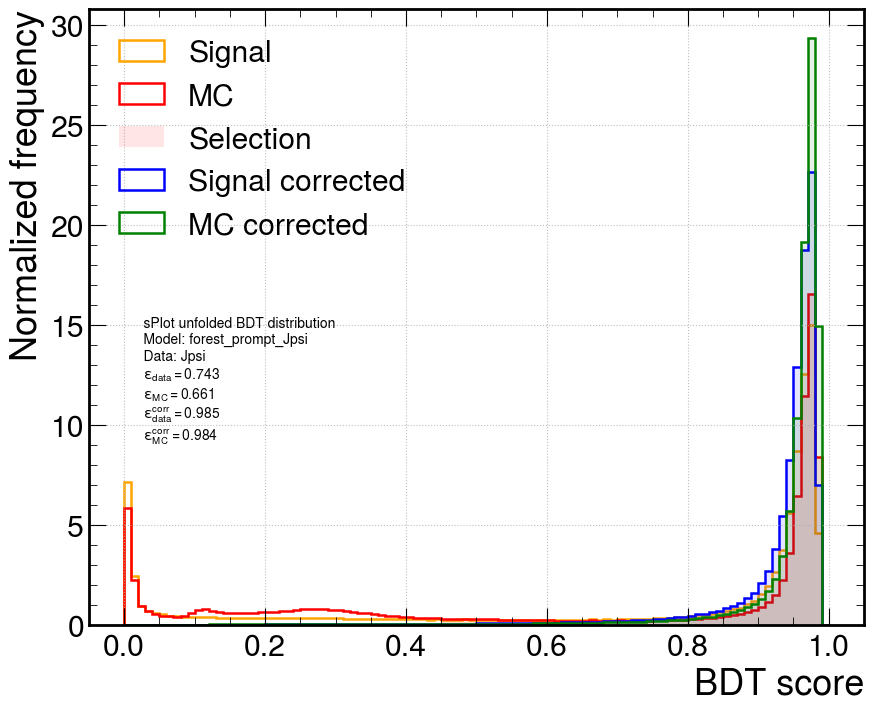

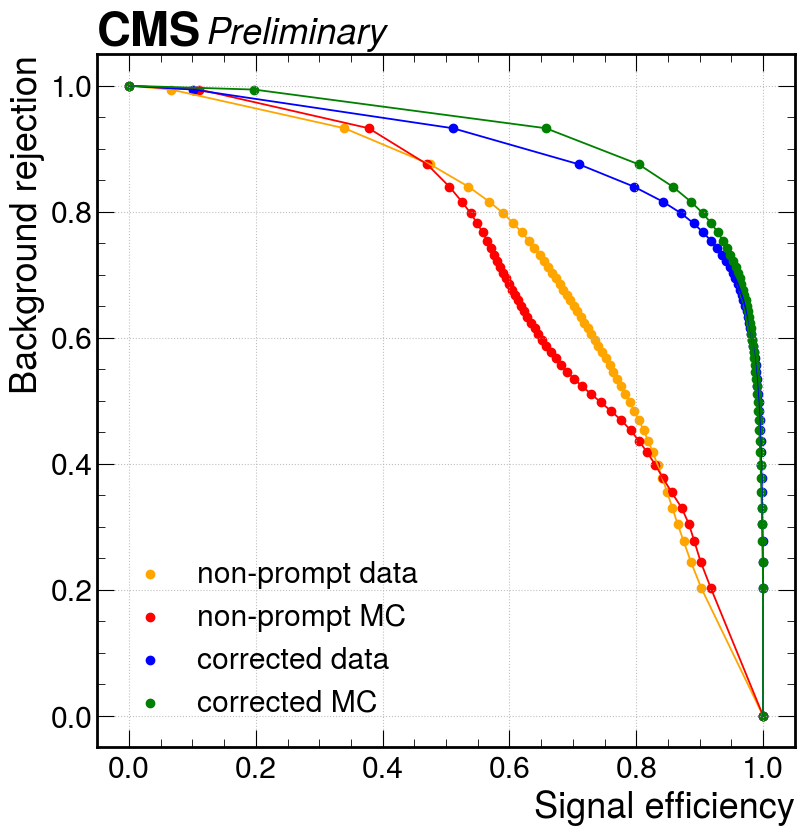

In [3]:
s=Sys(fJpsiData,fJpsiMC,"Jpsi")
s.define_cuts(0.4448979591836735,-2) #0.4448979591836735 #0.3836734693877551
s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=False)
s.study_efficiency("forest_prompt_Jpsi","Mm_kin_eta")
s.plot(plot_nonPrompt=True,plot_corr=True,plot_bkg=False)
Jpsi_on_Jpsi=s.plot_ROC()

Study efficiency of the BDT forest_standard_Y on the Jpsi peak
ID cut: -2
BDT cut: 0.4448979591836735
Total data signal yield:  677334.8685171269
Total MC signal yield:  606001.2986014483 


Efficiency data ID cut:  0.9999999999999434
Efficiency prompt data ID cut (only applies to Jpsi):  0.9999999999999853
Efficiency MC ID cut:  0.9999999999999685
Efficiency corrected MC ID cut (prompt and possible further correction):  1.0000000000000118 


dataYield_after_cuts: 0.56
MCYield_after_cuts: 0.53 


MC corr Yield_after_cuts 0.89 


BDT efficiency on Y peak: 
 On data: 0.5573459730288189 
 On corrected data: 0.814376174430382 
 On MC: 0.5343329519379806 
 On corrected MC: 0.8893799345135105
Efficiency difference: 0.07500376008312848


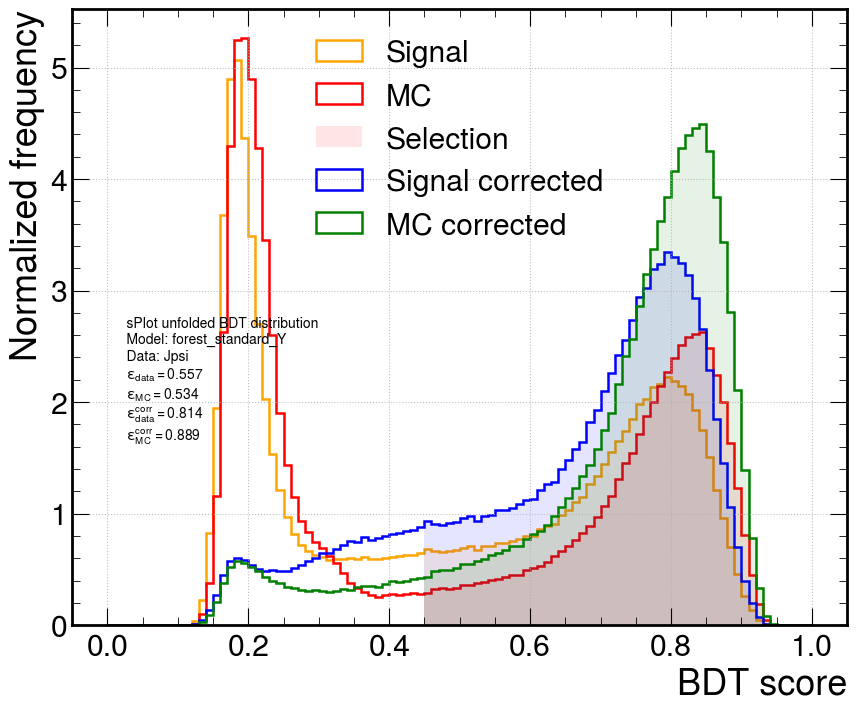

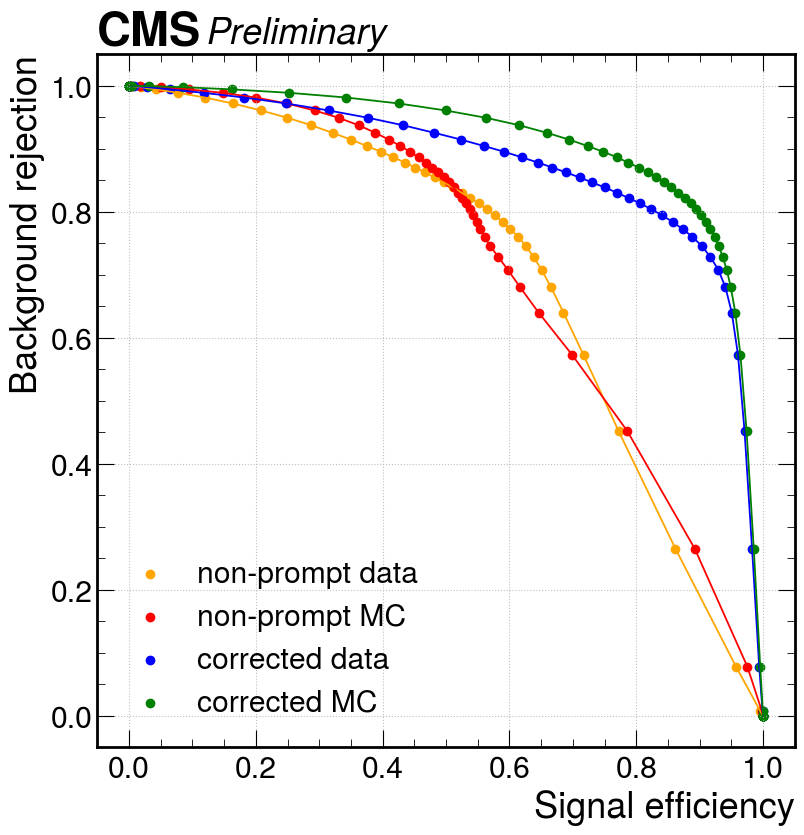

In [23]:
s=Sys(fJpsiData,fJpsiMC,"Jpsi")
s.define_cuts(0.4448979591836735,-2)
s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=False)
s.study_efficiency("forest_standard_Y",None)
s.plot()
Y_on_Jpsi=s.plot_ROC()


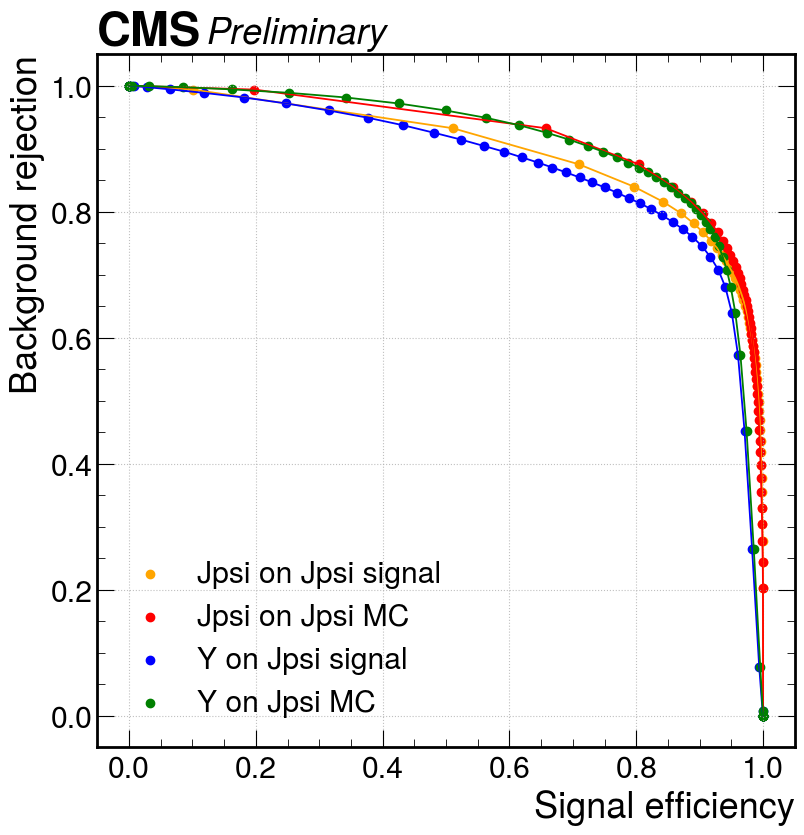

In [25]:
hep.style.use("CMS")
c = ["orange","red","blue","green"]
fig, ax = plt.subplots(figsize=(9,9))
hep.cms.text("Preliminary")

ax.scatter(Jpsi_on_Jpsi["corrected data"][0], Jpsi_on_Jpsi["corrected data"][1], color =c[0], zorder=0, label = "Jpsi on Jpsi signal")
ax.plot(Jpsi_on_Jpsi["corrected data"][0], Jpsi_on_Jpsi["corrected data"][1], lw=1.3, color = c[0])

ax.scatter(Jpsi_on_Jpsi["corrected MC"][0], Jpsi_on_Jpsi["corrected MC"][1], color =c[1], zorder=0, label = "Jpsi on Jpsi MC")
ax.plot(Jpsi_on_Jpsi["corrected MC"][0], Jpsi_on_Jpsi["corrected MC"][1], lw=1.3, color = c[1])

ax.scatter(Y_on_Jpsi["corrected data"][0], Y_on_Jpsi["corrected data"][1], color =c[2], zorder=0, label = "Y on Jpsi signal")
ax.plot(Y_on_Jpsi["corrected data"][0], Y_on_Jpsi["corrected data"][1], lw=1.3, color = c[2])

ax.scatter(Y_on_Jpsi["corrected MC"][0], Y_on_Jpsi["corrected MC"][1], color =c[3], zorder=0, label = "Y on Jpsi MC")
ax.plot(Y_on_Jpsi["corrected MC"][0], Y_on_Jpsi["corrected MC"][1], lw=1.3, color = c[3])
        
ax.set_xlabel('Signal efficiency')
ax.set_ylabel('Background rejection')
ax.grid(True)
ax.legend()
plt.show()

Study efficiency of the BDT forest_prompt_Jpsi on the Y peak
ID cut: -2
BDT cut: 0.4448979591836735
Total data signal yield:  415466.0128639216
Total MC signal yield:  209103.75792195203 


Efficiency data ID cut:  0.9999999999999697
Efficiency prompt data ID cut (only applies to Jpsi):  0.9999999999999986
Efficiency MC ID cut:  1.0000000000000069
Efficiency corrected MC ID cut (prompt and possible further correction):  0.9999999999999857 


dataYield_after_cuts: 0.99
MCYield_after_cuts: 0.98 


MC corr Yield_after_cuts 0.98 


BDT efficiency on Y peak: 
 On data: 0.9945908191441192 
 On corrected data: 0.9945908191441489 
 On MC: 0.9750323700942745 
 On corrected MC: 0.9802881364724831
Efficiency difference: -0.01430268267166579


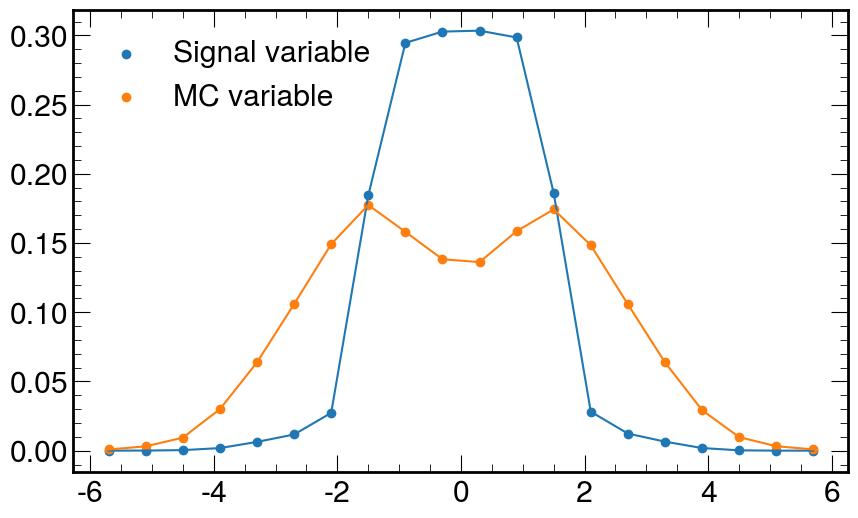

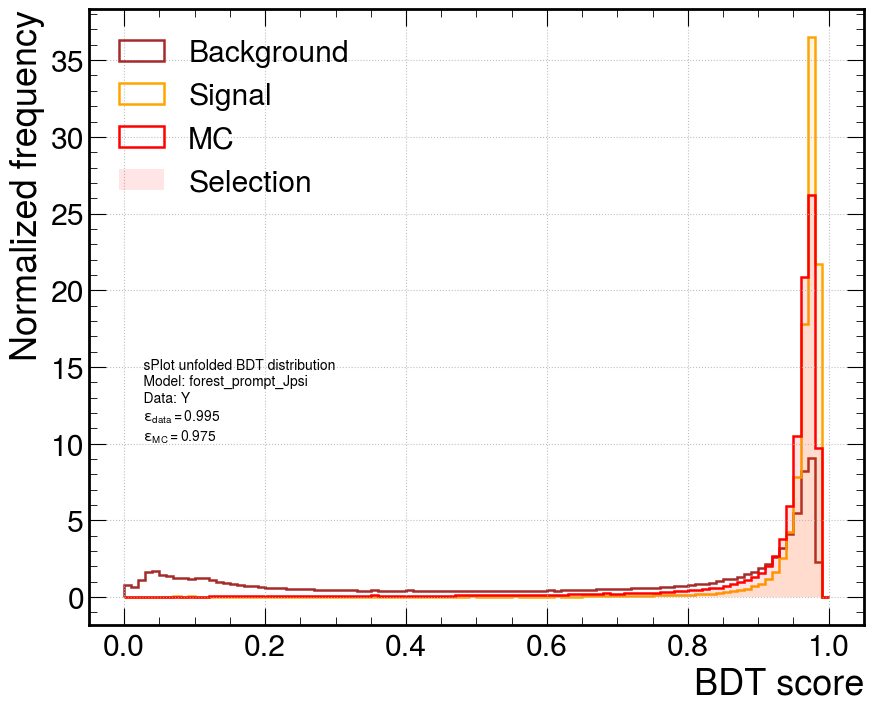

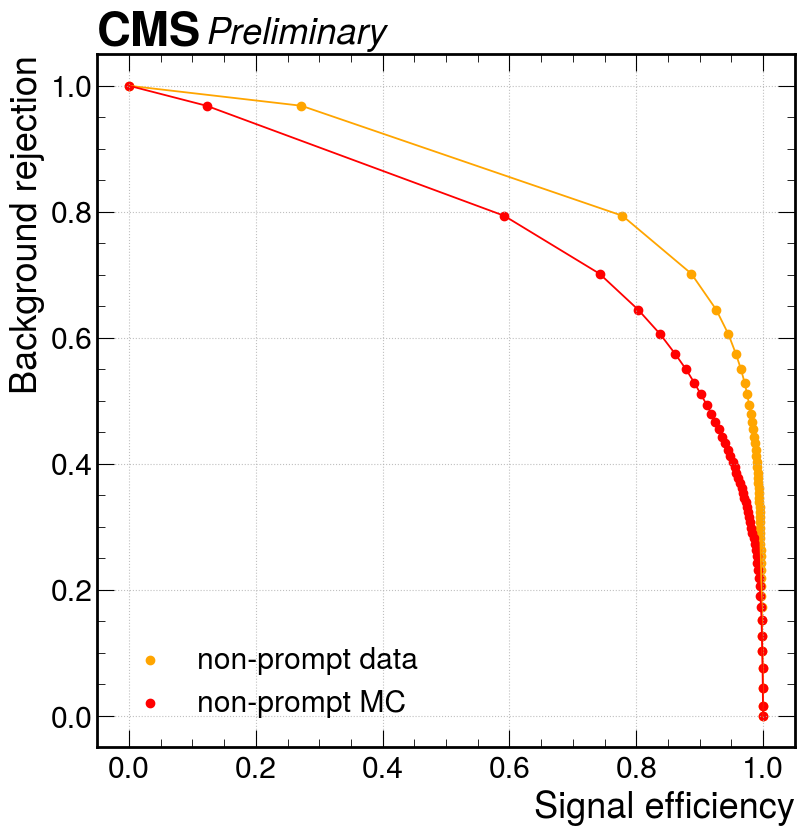

In [18]:
s=Sys(fYData,fYMC,"Y")
s.define_cuts(0.4448979591836735,-2)
s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=True)
s.study_efficiency("forest_prompt_Jpsi","Mm_kin_eta")
s.plot(plot_corr=False,plot_bkg=True)
Jpsi_on_Y = s.plot_ROC(plot_corr=False)

In [1]:
s=Sys(fYData,fYMC,"Y")
s.define_cuts(0.4448979591836735,-2)
s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=True)
s.study_efficiency("forest_standard_Y","Mm_kin_eta")
s.plot(plot_corr=True,plot_bkg=False)
Y_on_Y = s.plot_ROC(plot_corr=True,)


NameError: name 'Sys' is not defined

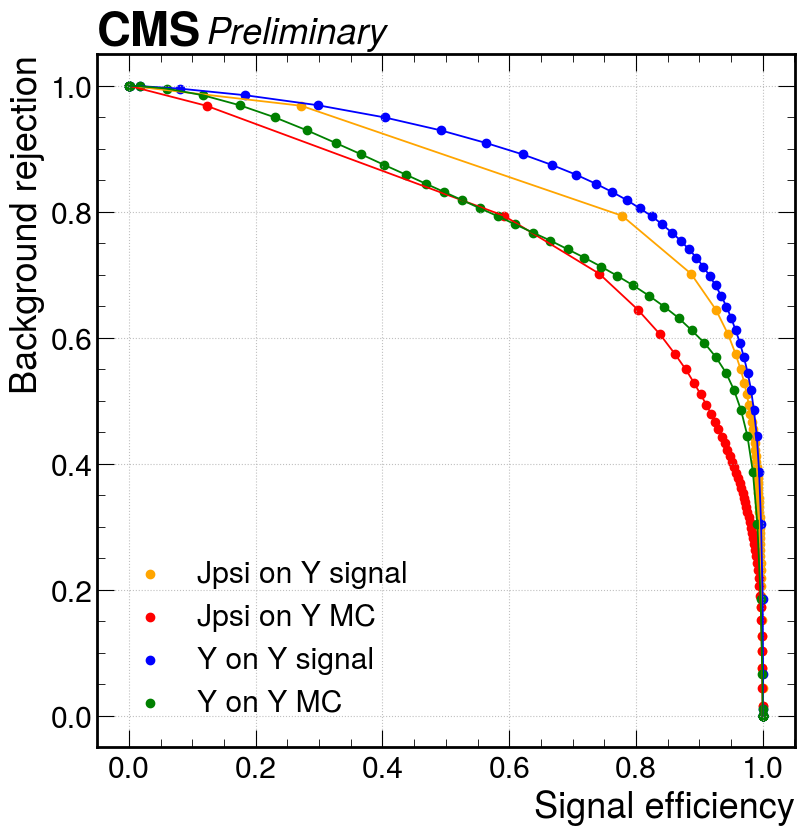

In [20]:
hep.style.use("CMS")
c = ["orange","red","blue","green"]
fig, ax = plt.subplots(figsize=(9,9))
hep.cms.text("Preliminary")

ax.scatter(Jpsi_on_Y["non-prompt data"][0], Jpsi_on_Y["non-prompt data"][1], color =c[0], zorder=0, label = "Jpsi on Y signal")
ax.plot(Jpsi_on_Y["non-prompt data"][0], Jpsi_on_Y["non-prompt data"][1], lw=1.3, color = c[0])

ax.scatter(Jpsi_on_Y["non-prompt MC"][0], Jpsi_on_Y["non-prompt MC"][1], color =c[1], zorder=0, label = "Jpsi on Y MC")
ax.plot(Jpsi_on_Y["non-prompt MC"][0], Jpsi_on_Y["non-prompt MC"][1], lw=1.3, color = c[1])

ax.scatter(Y_on_Y["non-prompt data"][0], Y_on_Y["non-prompt data"][1], color =c[2], zorder=0, label = "Y on Y signal")
ax.plot(Y_on_Y["non-prompt data"][0], Y_on_Y["non-prompt data"][1], lw=1.3, color = c[2])

ax.scatter(Y_on_Y["non-prompt MC"][0], Y_on_Y["non-prompt MC"][1], color =c[3], zorder=0, label = "Y on Y MC")
ax.plot(Y_on_Y["non-prompt MC"][0], Y_on_Y["non-prompt MC"][1], lw=1.3, color = c[3])
        
ax.set_xlabel('Signal efficiency')
ax.set_ylabel('Background rejection')
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
print(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full"))

/data/submit/mori25/dark_photons_ludo/DimuonTrees/sPlot/files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full


In [ ]:
def parse_text_file(filename):
    # Initialize an empty dictionary to store the results
    result_dict = {}
    
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            
            name = ""
            i=0

            for line in lines:
                i+=1
                # Remove leading and trailing whitespace
                line = line.strip()
                
                # Check if the line is not empty and starts with a double-quote
                if line and line.startswith('"'):
                    # Split the line by double-quotes
                    name = line.split('"')[1]
                    i=0
                
                if (i==2): 
                    val = line.split('"')[0] 
                    # Add the string and number to the dictionary
                    result_dict[name] = float(val)
    
    except FileNotFoundError:
        print(f"The file '{filename}' was not found.")
    
    return result_dict


In [ ]:

def plotPeak(mass,pars,components,range=None,title=None,plot_data=True):
    hep.style.use("CMS")
    cmap = plt.cm.tab10.colors
    fig, ax = plt.subplots(2,1,sharex = True,figsize=(12,9),gridspec_kw={'height_ratios': [2, 1]})

    w, xe = np.histogram(mass, bins=100, range = range)
    x = 0.5*(xe[:-1]+xe[1:])
    fine_x = np.linspace(x[0],x[-1],1000)
    werr = w ** 0.5
    dx = np.diff(xe)[0]

    names = components.keys()
    functions = [components[key] for key in names]

    ax[0].errorbar(x, w, werr, xerr=dx, fmt = 'o' , markersize = 3, capsize = 3, label="$m_{\mu\mu}^{off}$", color = "black", zorder=0)
    for f,name,color in zip(functions,names,cmap[:len(names)]):
        if (name=="Total"): ax[0].plot(fine_x, f(fine_x, *pars)*dx, lw=2, label=name, color = color, zorder=1)
        else: ax[0].plot(fine_x, f(fine_x, *pars)*dx, linestyle = '--', lw=1.5, label=name, color = color)

    ax[1].set_xlabel('Dimuon mass $m_{\mu\mu}$ [GeV]')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlim(range)
    # ax[0].set_ylim((0,1.2*dx*f(np.mean(globals()[peak+"_lims"]), *args)))
    ax[1].set_ylim(-1,1)
    ax[0].legend(title=title,fontsize=14,title_fontsize=16)
    ax[0].grid(True)

    # ax[1].errorbar(x, w/dx/pdf(x, *pars)[1], fmt = 's' ,  markersize = 4,capsize = 2, color = "blue")
    ax[1].errorbar(x, np.divide(ak.to_numpy(w)-dx*components["Total"](x, *pars), ak.to_numpy(w), out=np.zeros((nbins,)), where=ak.to_numpy(w) != 0), fmt = '.' , label =r"$\frac{data - fit}{data}$", markersize = 8,capsize = 2, color = "blue")
    ax[1].axhline(y=0, color='black', linestyle='--')
    ax[1].legend(loc="lower left", fontsize = 14,title_fontsize = 14)
    plt.subplots_adjust(hspace=0.)


jpsi_lims = 2.6,3.56
jpsi_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def jpsi_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def jpsi_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def jpsi_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_lims = 8.5,11.2
Y_MC_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def Y_MC_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def Y_MC_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def Y_MC_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_args = ["bkgYield", "bkgDecayConst", "sigYield", "alpha",  "sigmaL", "sigmaR", "mu1","mu2","mu3", "sigma1","sigma2","sigma3", "n1","n2", "n3", "GaussFraction", "fracY2", "fracY3"]
def Y_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst)
                    

In [ ]:
filename = "SPlotJpsi_fit_MC_lxy.dot"
jpsi_MC_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiMC["Mm_mass"],[jpsi_MC_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ MC peak fit")

In [ ]:
filename = "SPlotJpsi_fit_data_lxy.dot"
jpsi_data_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiData["Mm_mass"],[jpsi_data_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ data peak fit")

In [ ]:
filename = "SPlotY_fit_MC_lxy.dot"
Y_MC_pars = parse_text_file(filename)
components = {"Total":Y_MC_dCB_pdf, "Signal (Gaussian + dCB)":Y_MC_dCB_pdf_sig, "Background (Falling exp.)":Y_MC_dCB_pdf_bkg }
plotPeak(fYMC["Mm_mass"],[Y_MC_pars[key] for key in Y_MC_args],components, range = Y_lims, title="Y MC peak fit")
print(fYMC["Mm_mass"])

In [ ]:
filename = "SPlotY_fit_data_lxy.dot"
Y_pars = parse_text_file(filename)
print(Y_pars)



Y_pars["n3"]=1.5




components = {"Total":Y_dCB_pdf, "Signal (Gaussian + dCB)":Y_dCB_pdf_sig, "Background (Falling exp.)":Y_dCB_pdf_bkg }
plotPeak(fYData["Mm_mass"],[Y_pars[key] for key in Y_args],components, range = Y_lims, title="Y Data peak fit")

In [ ]:

jpsi_args = {"bkgYield":{"in":1e3, "range": (0,1e6)}, 
             "bkgDecayConst":{"in":-0.8, "range": (-1,-0.1)},
             "sigYield":{"in":8e3, "range": (0,1e6)}, 
             "mu":{"in":3.094, "range": (3,3.2)}, 
             "sigmaL":{"in":0.02, "range": (0,.1)}, 
             "alphaL":{"in":3, "range": (0,5)}, 
             "nL":{"in":1, "range": (0,10)}, 
             "sigmaR":{"in":0.02, "range": (0,.1)}, 
             "alphaR":{"in":1.8, "range": (0,5)}, 
             "nR":{"in":1, "range": (0,10)}, 
             "GaussFraction":{"in":0.6, "range": (0,1)}, 
             "sigma":{"in":0.02, "range": (0,0.1)}}

# cf_Phi = ExtendedUnbinnedNLL(ak.to_numpy(fJpsiData["Mm_mass"][:10000]),jpsi_dCB_pdf)
# iv = [jpsi_args[key]["in"] for key in jpsi_args.keys()]
# mJpsi = Minuit(cf_Phi,*iv)
# mJpsi.limits = [jpsi_args[key]["range"] for key in jpsi_args.keys()]


# mJpsi.fixed["bkgDecayConst"] = True
# mJpsi.fixed["sigma"] = True

# mJpsi.fixed["nR"] = True
# mJpsi.fixed["sigmaL"] = True
# mJpsi.fixed["alphaL"] = True
# mJpsi.fixed["nL"] = True
# mJpsi.fixed["sigmaR"] = True

# mJpsi.migrad()#ncall=100000 , iterat/e = 10)
# mJpsi.hesse()   
# mJpsi.interactive()